# Recommendations with IBM

In this notebook, we will be implementing the recommendation engine for IBM Watson Studio platform. Different recommendation methods are meant to be used in different situations.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

Importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

Explore the data. Each email contains a unique user and each title contains a unique article. However, we want to make sure that there are no duplicated or typo in article's title that do not match the corresponding id.

In [2]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


The graph shows a distribution of how many articles a user interacts with in the dataset. The data follows a poisson distribution in which most users interact with less than 10 articles.

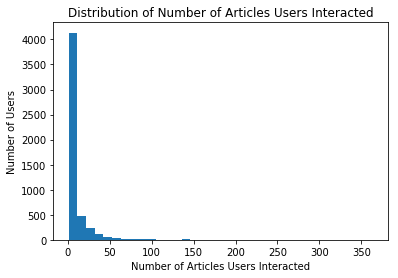

In [3]:
df.groupby('email').count()['article_id'].sort_values(ascending=False).plot(kind='hist', bins=35)
plt.xlabel('Number of Articles Users Interacted')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Articles Users Interacted');

In [4]:
# Display the median and maximum number of user_article interactios below
median_val = df.groupby('email').count()['article_id'].median()
max_views_by_user = df.groupby('email').count()['article_id'].max()

In [5]:
print('Median of user-article interaction is {}'.format(median_val))
print('Maximum number of user-article interactions is {}'.format(max_views_by_user))

Median of user-article interaction is 3.0
Maximum number of user-article interactions is 364


Remove duplicate articles from the **df_content** dataframe.  

In [6]:
def find_duplicate_data(df, columns):
    '''
    the function finds the duplicated data
    INPUT-
    df - dataframe to eliminate duplicate data
    columns - the column to check for the duplicate data (str)
    
    OUTPUT-
    non_duplicated_df - duplicated rows of data
    
    '''
    
    return df[df[columns].duplicated() == True]

In [7]:
# Find and explore duplicate articles
find_duplicate_data(df_content, 'article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
def df_non_duplicated(df, index_to_drop):
    '''
    This function output the non-duplicated dataframe
    INPUT-
    df - dataframe to eliminate duplicate data
    index_to_drop - rows to drop (arr)
    
    OUTPUT-
    df_dropped - df with duplicated rows removed
    
    '''
    df_dropped = df.drop(index_to_drop, axis = 0).reset_index().drop('index', axis =1)
    return df_dropped

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_non_duplicated = df_non_duplicated(df_content, find_duplicate_data(df_content, 'article_id').index)

In [10]:
df_non_duplicated.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


Find descriptive statistics about the data such as :

- The number of unique articles that have an interaction with a user.                                                         
- The number of unique articles in the dataset (whether they have any interactions or not).
- The number of unique users in the dataset. (excluding null values) <br>
- The number of user-article interactions in the dataset.

In [11]:
unique_articles = df.groupby('article_id')['email'].count().shape[0] # The number of unique articles that have at least one interaction
total_articles = df_non_duplicated.nunique()['article_id'] # The number of unique articles on the IBM platform
unique_users = df.nunique()['email'] # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [12]:
print('The number of unique articles is {}.'.format(unique_articles))
print('The number of total articles is {}.'.format(total_articles))
print('The number of unique users is {}.'.format(unique_users))
print('The number of user-article interactions is {}.'.format(user_article_interactions))

The number of unique articles is 714.
The number of total articles is 1051.
The number of unique users is 5148.
The number of user-article interactions is 45993.


Examine the most viewed article_id as well as how often it was viewed. The email_mapper function was a reasonable way to map users to ids. With the small values of nulls, it is assumed that the nulls are belonged to a single user.

In [32]:
most_viewed_article_id = df.groupby('article_id')['email'].count().sort_values(ascending=False).head(1).index[0].astype(str)
max_views = df.groupby('article_id')['email'].count().sort_values(ascending=False).head(1).values[0]

In [35]:
print('Most Viewed Article Id is {}.'.format(most_viewed_article_id))
print('The maximum view of the most viewed article id is {}.'.format(max_views))

Most Viewed Article Id is 1429.0.
The maximum view of the most viewed article id is 937.


In [96]:
def email_mapper():
    '''
    This function map users to ids. 
    #OUTPUT
    #user-id : mapped user_id 
    '''
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

df.head()

,article_id,title,interaction,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,1
1,1314.0,healthcare python streaming application demo,1,2
2,1429.0,use deep learning for image classification,1,3
3,1338.0,ml optimization using cognitive assistant,1,4
4,1276.0,deploy your python model as a restful api,1,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Since we do not have article ratings we can only organize the popularity of an article on how often an article was interacted with. We are interested in getting the n top articles ordered with most interactions as the top.


In [42]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.groupby('title').count().sort_values('user_id', ascending=False).index[:n])
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.groupby('article_id').count().sort_values('user_id', ascending=False).index[:n])
    return top_articles # Return the top article ids

In [45]:
print('The top 5 article titles are {}.'.format(get_top_articles(5)))
print('The top 5 article ids are {}.'.format(get_top_article_ids(5)))

The top 5 article titles are ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm'].
The top 5 article ids are [1429.0, 1330.0, 1431.0, 1427.0, 1364.0].


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


The **df** dataframe needed to be reformatted to be shaped with users as the rows and articles as the columns.  

* Each user appears in each row once.

* Each article shows up in one column.  

* 1's in the matrix indicate that a user has interacted with an article at least once. 0's indicate that a user has not interacted with an item. 


In [97]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df['interaction'] = 1
    user_item = df[['article_id', 'user_id', 'interaction']].groupby(['user_id', 'article_id']).max().unstack()
    user_item.fillna(0, inplace=True)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [47]:
## Tests: test the user matrix data structure shape
assert user_item.shape[0] == 5149, "The number of users is supposed to be 5149."
assert user_item.shape[1] == 714, "The number of articles in the user-article matrix is supposed to be 714."
assert user_item.sum(axis=1)[1] == 36, "The number of articles seen by user 1 supposed to be 36."
print("User-article matrix has the right data shape!")

User-article matrix has the right data shape!


Find the similar users of the input user_id by using dot product since the results for each user here are binary. The dot products of two users represent the similarity.

In [63]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = {}
    for user in user_item.index:
        similarity[user] = np.dot(user_item.loc[user_id,:], user_item.loc[user,:])
    # sort by similarity
    similarity_sorted = {k: v for k, v in sorted(similarity.items(), reverse=True, key=lambda item: item[1])}
    # remove the own user's id
    similarity_sorted.pop(user_id)
    # create list of just the ids
    most_similar_users = [k for k,v in similarity_sorted.items()]   
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [64]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


The function above provides the most similar users to each user, then it is desired to find articles that other similar users have interacted with. However, we want to exclude the articles that the user have already seen. If the function calls n number of articles and we run out of recommended articles, an arbitary articles will be given.

In [65]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = [df[df['article_id'] == float(id)]['title'].values[0] for id in article_ids]
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = list(map(str, map(float, user_item.loc[user_id,:][user_item.loc[user_id]==1]['interaction'].index)))
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = []
    most_similar_users = find_similar_users(user_id)
    user_id_articles, user_id_article_names = get_user_articles(user_id)
    for user in most_similar_users:
        article_ids, articles_names = get_user_articles(user)
        for id in article_ids:
            if id not in user_id_articles:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
            break

    if len(recs) < m:
        for id in str(df['article_id']):
            if id not in the_user_articles:
                recs.append(id)
            if len(recs) >= m:
                break
    return recs # return your recommendations for this user_id    

In [66]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [68]:
# Test functions
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("Test passed!")

Test passed!


There are some issues with the user_user_recs function since the function rates the similar users solely based on the similarity and arbitarily given the articles ids associated with those individuals. Since there is no rating, the articles is arbitarily recommended. In the case that we have multiple users with the same similarity, we want to choose the users with more article interactions before choosing those with fewer interactions. We also want to recommend the articles based on higher interactions than those with less interactions. Lastly, if we call for m number of articles and we run of the recommended articles, the most popular articles will be recommended instead of arbitarily given.

In [69]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
    
    for user in user_item.index:
        if user == user_id:
            continue
        neighbors_df.loc[user] = [user, np.dot(user_item.loc[user_id,:], user_item.loc[user,:]), df[df['user_id'] == user]['article_id'].count()]
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Users that have the most total article interactions are chosen 
    before choosing those with fewer article interactions.

    * Articles with the most total interactions are chosen 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = []
    most_similar_users = find_similar_users(user_id)
    user_id_articles, user_id_article_names = get_user_articles(user_id)
    for user in get_top_sorted_users(user_id).index:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if id not in user_id_articles:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
            break
            
    if len(recs) < m:
        for id in [str(id) for id in get_top_article_ids(100)]:
            if id not in user_id_articles:
                recs.append(id)
            if len(recs) >= m:
                break
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [70]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications']


Test user1 and user131 dictionary with the functions

In [73]:
user1_most_sim = find_similar_users(1)[0]# Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9]# Find the 10th most similar user to user 131

In [74]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


As user-user collaborative filtering relies on existing data of a user in order to find the most similar users in order to give recommendations of the articles that those users have interacted with. Without any exisitng data, we will not be able to compute the most similar users. This issues is typical in various recommendation system platforms and can be addressed in many ways (cold start problem) . The way that we are taking here is to recommend the most popular articles to the new users until sufficient interaction data is collected.

The top 10 recommended articles are provided for new user with the tested function.

In [79]:
new_user = '0.0'

# simulate a new user id of 0
# new_user_recs will recommend the top 10 articles_ids 
new_user_recs = list(map(str, map(float, get_top_article_ids(10))))

In [80]:
def article_ids_string(article_ids):
    '''
    INPUT
    article_ids (list) - list of article_ids in numeric type
    
    OUTPUT
    article_ids_string (list) - list of article_ids converted from int to float to string
    '''
    
    article_ids_string = list(map(str,map(float,article_ids)))
    return article_ids_string

In [81]:
new_user_recs = article_ids_string(get_top_article_ids(10))

In [82]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "We want to recommend the most popular articles since we have no user information."
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will build matrix factorization from scratch to make article recommendations to the users on the IBM Watson Studio platform.

In [84]:
# Load the matrix 
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [85]:
user_item_matrix = create_user_item_matrix(df)

In [86]:
# user-item matrix quick look
user_item_matrix.head()

interaction                                                   \
article_id      0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0     
user_id                                                                   
1                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3                  0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
4                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                          ...                                              \
article_id 16.0   18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0   
user_id                   ...                                               
1             0.0    0.0  ...      0.0    0.0    1.0    0.0    1.0    0.0   
2             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0  ...      0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   

                                        
article_id 1441.0 1442.0 1443.0 1444.0  
user_id                                 
1             0.0    0.0    0.0    0.0  
2             0.0    0.0    0.0    0.0  
3             0.0    0.0    0.0    0.0  
4             0.0    0.0    0.0    0.0  
5             0.0    0.0    0.0    0.0  

[5 rows x 714 columns]

We use numpy to perform singular value decomposition with only values of 0 and 1. In other typical recommendation plaform we could have our numerical ratings (0-10) or categorical ratings (low-medium-high). Binary ratings is tricky since there is no way for us to know how good our recommendation system performance is since we do not have the ratings given. We can go about this by splitting dataset into train and test data and find the number of latent features that has the highest train and test accuracy score.

In [89]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

Examine how the accuracy score changes with the number of latent features.

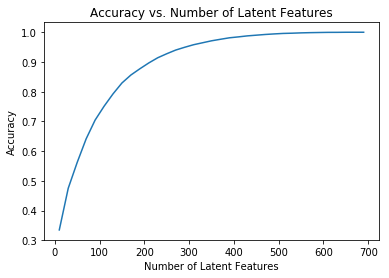

In [88]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown below.

We mentioned earlier that one of the main issues for recommendation prediction is the cold start problem, when we do not have information about the new users. We have seen earlier that most users have interacted with less than 5 or fewer indicating either there are not engaging or they are new users. Some questions that we need to consider are the following :



* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [98]:
#split the dataset
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.values
    test_arts = user_item_test['interaction'].columns.values
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [107]:
#common user in test and train
common_idx = user_item_train.index.isin(test_idx)

In [131]:
# users we can make predictions for in test set
print('The number of user we can make predictions in the test set is {}.'.format(common_idx.sum()))

The number of user we can make predictions in the test set is 20.


In [128]:
#user we cannot make prediction
print('The percentage of user we cannot make prediction is {} %.'.format(round(((user_item_test.shape[0] - common_idx.sum()) / user_item_test.shape[0]) * 100,1)))

The percentage of user we cannot make prediction is 97.1 %.


All of the test movies are in the training data, but there are only 20 test users that were also in the training set. All of the other users that are in the test set we have no data on. Therefore, we cannot make predictions for these users using SVD.

Decompose user_item_train dataset and also subset the rows in the user_item_test dataset that we can predict using this matrix decomposition with different numbers of latent features to see which features to pick based on the accuracy of the test data.

Explore how well SVD works towards making predictions for recommendations on the test data.  

In [133]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [134]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [135]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
common_idx = user_item_train.index.isin(test_idx)
common_arts = user_item_train['interaction'].columns.isin(test_arts)

u_test = u_train[common_idx,:]
vt_test = vt_train[:, common_arts]

In [136]:
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

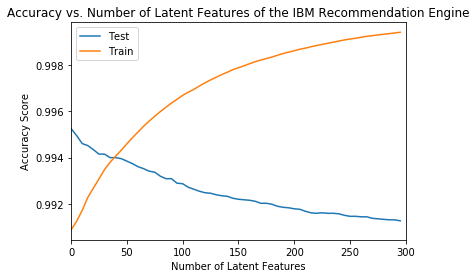

In [149]:
latent_feature_nums = np.arange(0,300,5)
test_sum_errs, train_errs = [], []

for num in latent_feature_nums:
    s_num, u_train_num, vt_train_num = np.diag(s_train[:num]), u_train[:,:num], vt_train[:num,:]
    u_test_num, vt_test_num = u_test[:,:num], vt_test[:num,:]
    
    user_test_item_pred = np.around(np.dot(np.dot(u_test_num, s_num),vt_test_num))
    
    test_diffs = np.subtract(user_item_test.loc[user_item_matrix.loc[common_idx,:].index,:], user_test_item_pred)
    
    user_item_train_preds = np.around(np.dot(np.dot(u_train_num, s_num), vt_train_num))
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    test_sum_errs.append(test_err)
    
    
plt.figure()
plt.plot(latent_feature_nums, 1- np.array(test_sum_errs)/df.shape[0], label='Test')
plt.plot(latent_feature_nums, train_errs, label='Train')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy Score')
plt.xlim((0,300))
plt.title('Accuracy vs. Number of Latent Features of the IBM Recommendation Engine')
plt.legend();

The accuracy score for the model is extremely high. This is because we do not have enough data for the number of users we can predict. We also have extremely unbalanced class with many user-article interactions contains 0 instead of 1. As of now we can only predict 20 users. This trend seems similar to the bias-variance tradeoff graph. The number of features represent the model complexity. The lower the complexity will be able to generalize better. However, we also want to optimize the accuracy score in the training set by increasing the model complexity. We would pick the number of features around 45 that achieve good model complexity and able to deal with data variance. Once we have more interactions data, our test user numbers will grow and we will be able to use other techniques such as k-fold cross validation to validate our model. We could also implement FunkSVD if the users are new instead of assuming 0's we could assume those are missing values and use gradient descent to obtain suitable number of features.


From the above, we saw that increasing the latent features seems to have an unproportional relationships to the accuracy of the prediction. In order to determine whether the recommendations we have made are an improvement on how users currently find articles we can potentially run an A/B Test where A (control) is the current method of users finding articles and B (treatment) is the method with our recommendation system implemented. Hypothesis testing needed to be conducted in a randomized and controlled manners and we can evaluated whethere there is a significant increase is user-article interactions between treatment vs. control groups.